## Notebook para comparar RNN

<b>Vamos os dados do mfcc </b>
- Vamos testar sem dropouts nem regularizer

- Apenas regularizer

- Apenas dropout

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
from tensorflow.keras import Sequential, regularizers
from tensorflow.keras.layers import LSTM, Dense, Dropout, TimeDistributed, Flatten, Bidirectional
from sklearn.metrics import confusion_matrix
import keras
import os
import gc

In [2]:
def plot_graphs(m_metrics):
    class_labels = [i for i in range(10)]
    history = m_metrics.get('history_dict')
     
    # Create a 1x3 grid for subplots
    fig, axs = plt.subplots(1, 3, figsize=(18, 4))

    # Plot accuracy values
    axs[0].plot(history['accuracy'])
    axs[0].plot(history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['Train', 'Validation'], loc='upper left')

    # Plot loss values
    axs[1].plot(history['loss'])
    axs[1].plot(history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['Train', 'Validation'], loc='upper left')

    # Plot confusion matrix
    cm = m_metrics.get('confusion_matrix')
    axs[2].set_title('Confusion Matrix')
    axs[2].set_xlabel('Predicted')
    axs[2].set_ylabel('True')
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels, ax=axs[2])

    # Adjust layout
    plt.tight_layout()
    plt.show()

In [5]:
def padding(path, duration = 4, sr = 44100):
    files = librosa.util.find_files(path)
    data = []

    for index, file_path in enumerate(files):
        try:
            audio, sr = librosa.load(file_path, sr=sr, mono=True)

            if len(audio) < duration*sr: # quando a duracao do audio for inferior aos 4 seg vamos adicionar padding
                audio = np.concatenate([audio,np.zeros(shape = (duration*sr - len(audio), ))])

            elif len(audio) > duration*sr: # quando a duracao do audio for superior aos 4 segs vamos reduzir a duracao
                audio = audio[:duration*sr]
        
            file_name = os.path.basename(file_path)
            data.append([file_name, audio])
        
        except Exception:
            print(f"Error in processig file {file_path}: {Exception}")

    return data


def feature_extraction(dataframe, audios):
    mfcc_coeficients = []
    labels = []

    for index in range(len(audios)):
        try:
            file_name =audios[index][0]
            if file_name:
                row = dataframe.loc[dataframe["slice_file_name"] == file_name]

                if not row.empty:
                    label = row.iloc[0,6]
                    mfcc = librosa.feature.mfcc(
                        y = audios[index][1],
                        n_mfcc = 13, 
                        hop_length = 512
                    )
                    mfcc = (mfcc - np.mean(mfcc)) / np.std(mfcc)
                    mfcc_coeficients.append(mfcc)
                    labels.append(label)
        except Exception:
            print(f"Error in processig file {audios[index][0]}: {Exception}")

    mfcc_coeficients = np.array(mfcc_coeficients)
    labels = np.array(labels)
    return mfcc_coeficients, labels

### Data Extraction

In [15]:
fold_paths = ["../UrbanSound8K/audio/fold1",
              "../UrbanSound8K/audio/fold2",
              "../UrbanSound8K/audio/fold3",
              "../UrbanSound8K/audio/fold4",
              "../UrbanSound8K/audio/fold5",
              "../UrbanSound8K/audio/fold6",
              "../UrbanSound8K/audio/fold7",
              "../UrbanSound8K/audio/fold8",
              "../UrbanSound8K/audio/fold9",
              "../UrbanSound8K/audio/fold10"]

df = pd.read_csv("../UrbanSound8K/metadata/UrbanSound8K.csv")

features = np.empty((10,), dtype=object)
label = np.empty((10,), dtype=object)

for i, fold in enumerate(fold_paths):
    print(f"Processing Fold Number {i+1}")
    audio_data = padding(fold)

    mfcc, labels = feature_extraction(df, audio_data)
    # mfcc = mfcc.transpose(0,2,1)
    
    encoded_labels = np.zeros((len(labels), 10))
    encoded_labels[np.arange(len(labels)), labels] = 1
    
    features[i] = mfcc
    label[i] = encoded_labels
    print("Features Shape: ",features[i].shape)
    print("Labels Shape: ",label[i].shape,"\n")
    
    del mfcc
    del labels
    del encoded_labels
    gc.collect() # libertar memoria

Processing Fold Number 1
Features Shape:  (873, 13, 345)
Labels Shape:  (873, 10) 

Processing Fold Number 2
Features Shape:  (888, 13, 345)
Labels Shape:  (888, 10) 

Processing Fold Number 3
Features Shape:  (925, 13, 345)
Labels Shape:  (925, 10) 

Processing Fold Number 4
Features Shape:  (990, 13, 345)
Labels Shape:  (990, 10) 

Processing Fold Number 5
Features Shape:  (936, 13, 345)
Labels Shape:  (936, 10) 

Processing Fold Number 6
Features Shape:  (823, 13, 345)
Labels Shape:  (823, 10) 

Processing Fold Number 7
Features Shape:  (838, 13, 345)
Labels Shape:  (838, 10) 

Processing Fold Number 8
Features Shape:  (806, 13, 345)
Labels Shape:  (806, 10) 

Processing Fold Number 9
Features Shape:  (816, 13, 345)
Labels Shape:  (816, 10) 

Processing Fold Number 10
Features Shape:  (837, 13, 345)
Labels Shape:  (837, 10) 



### Modelos

In [16]:
def create_model1(x, y):
    input_shape = (x,y)  # Shape do set de treino
    model = Sequential()
    # LSTM layers
    model.add(LSTM(128, return_sequences=True, activation='tanh', kernel_initializer='random_normal',input_shape=input_shape))
    model.add(Bidirectional(LSTM(64, return_sequences=True, activation='tanh')))
    # TimeDistributed Dense layers
    model.add(TimeDistributed(Dense(64, activation='tanh')))
    model.add(TimeDistributed(Dense(32, activation='tanh')))
    model.add(TimeDistributed(Dense(16, activation='tanh')))
    model.add(TimeDistributed(Dense(8, activation='tanh')))
    # Pooling to reduce sequence
    model.add(Flatten())
    # Output layers
    model.add(Dense(10, activation='softmax'))
    return model

def create_model2(x, y):
    input_shape = (x,y)  # Shape do set de treino
    model = Sequential()
    # LSTM layers
    model.add(LSTM(128, return_sequences=True, activation='tanh', kernel_initializer='random_normal',input_shape=input_shape))
    model.add(Bidirectional(LSTM(64, return_sequences=True, activation='tanh')))
    # TimeDistributed Dense layers
    model.add(TimeDistributed(Dense(64, activation='tanh', kernel_regularizer=regularizers.l2(0.01))))
    model.add(TimeDistributed(Dense(32, activation='tanh', kernel_regularizer=regularizers.l2(0.01))))
    model.add(TimeDistributed(Dense(16, activation='tanh', kernel_regularizer=regularizers.l2(0.01))))
    model.add(TimeDistributed(Dense(8, activation='tanh', kernel_regularizer=regularizers.l2(0.01))))
    # Pooling to reduce sequence
    model.add(Flatten())
    # Output layers
    model.add(Dense(10, activation='softmax'))
    return model

def create_model3(x, y):
    input_shape = (x,y)  # Shape do set de treino
    model = Sequential()
    # LSTM layers
    model.add(LSTM(128, return_sequences=True, activation='tanh', kernel_initializer='random_normal',input_shape=input_shape))
    model.add(Bidirectional(LSTM(64, return_sequences=True, activation='tanh')))
    # TimeDistributed Dense layers
    model.add(TimeDistributed(Dense(64, activation='tanh')))
    model.add(Dropout(0.4))
    model.add(TimeDistributed(Dense(32, activation='tanh')))
    model.add(Dropout(0.4))
    model.add(TimeDistributed(Dense(16, activation='tanh')))
    model.add(Dropout(0.4))
    model.add(TimeDistributed(Dense(8, activation='tanh')))
    model.add(Dropout(0.3))
    # Pooling to reduce sequence
    model.add(Flatten())
    # Output layers
    model.add(Dense(10, activation='softmax'))
    return model

### Definir fold
Vamos definir o fold 1 como teste e o fold 2 como validação

In [17]:
EPOCHS = 50
sets_treino_val = [[0,1],[1,2],[2,3],[3,4],[4,5],[5,6],[6,7],[7,8],[8,9],[9,0]] # [set_test,set_valid] | 0 = fold1 | 1 = fold2 | ...
X_test, y_test =[], []
X_val, y_val = [], []
X_train, y_train = [], []
fold = 0

# separar os dados(folds) em test(1) | validacao(1) | treino(8)
for i in range(10):
    if i == sets_treino_val[fold][0]:
        # set de teste
        X_test = features[i]
        y_test = label[i]
    elif i == sets_treino_val[fold][1]:
        # set de validacao
        X_val = features[i]
        y_val = label[i]
    else:
        # agrupar sets para treino
        if len(X_train) == 0:  # inicializar no primeiro fold de treino
            X_train = features[i]
            y_train = label[i]
        else:
            X_train = np.concatenate((X_train, features[i]), axis=0)
            y_train = np.concatenate((y_train, label[i]), axis=0)

# converter para np array caso ainda nao estejam
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)
X_val = np.array(X_val)
y_val = np.array(y_val)


### Sem dropout nem Regularizer

Epoch 1/50


c:\Users\joaob\virt_env\aprend_comp_2\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


218/218 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.0928 - loss: 2.3849 - val_accuracy: 0.2455 - val_loss: 2.0944
Epoch 2/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.2210 - loss: 2.0816 - val_accuracy: 0.2669 - val_loss: 2.0376
Epoch 3/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.2526 - loss: 1.9979 - val_accuracy: 0.2939 - val_loss: 1.8096
Epoch 4/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.3117 - loss: 1.8680 - val_accuracy: 0.3502 - val_loss: 1.7375
Epoch 5/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.3586 - loss: 1.7765 - val_accuracy: 0.3660 - val_loss: 1.7082
Epoch 6/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.3812 - loss: 1.7174 - val_accuracy: 0.3221 - val_loss: 1.7147
Epoch 7/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.4403 - loss: 1.6064 - val_accuracy: 0.3266 - val_loss: 1.7148
Epoch 8/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.4759 - loss: 1.5098 - val_accuracy: 0.3277

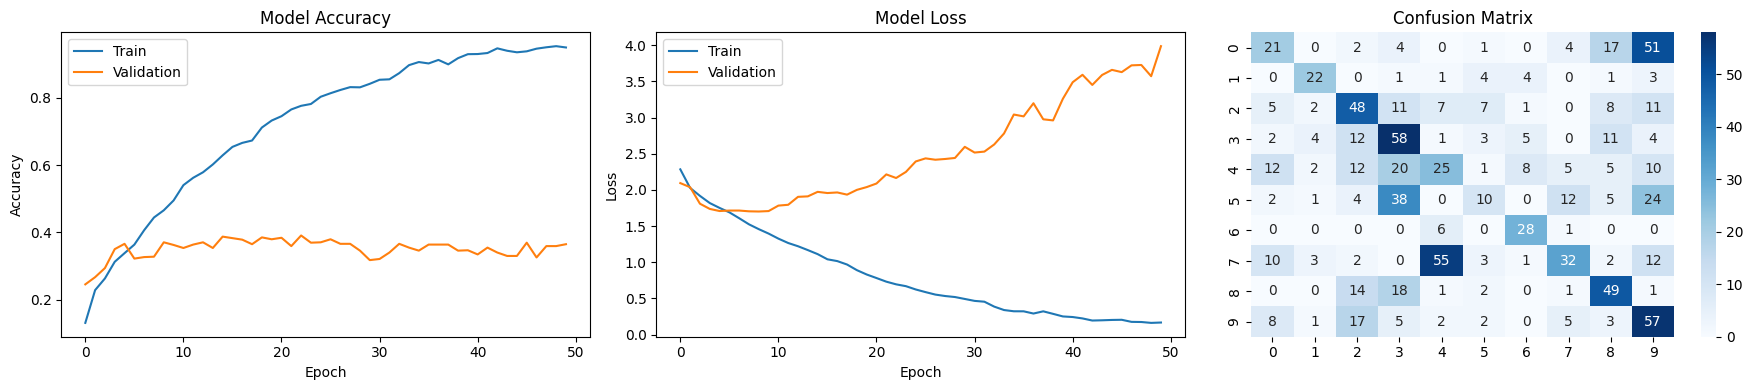

In [18]:
model = create_model1(13, 345)
# compilar o modelo com o optimizer Adam
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(
    optimizer=optimizer, 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)
# treinar o modelo
LSTM_model = model.fit(
    X_train, y_train, 
    epochs=EPOCHS,
    batch_size=32, 
    shuffle=False, 
    validation_data=(X_val, y_val)
)
# prever no set de test
y_pred = model.predict(X_test)

# avaliar o modelo
y_pred_reshape = np.argmax(y_pred, axis=1)
y_test_reshape = np.argmax(y_test, axis=1)
TestLoss, Testacc = model.evaluate(X_test, y_test)

# guardar os resultados para o guardar disco/visualizar no futuro
m_metrics1 = {
    'loss': TestLoss, 
    'accuracy': Testacc, 
    'confusion_matrix': confusion_matrix(y_test_reshape, y_pred_reshape), 
    'history': model, 
    'history_dict': LSTM_model.history
}

# eliminar o modelo para começar de novo para evitar memory leak
del model
keras.backend.clear_session()
gc.collect()

print("Done.")
plot_graphs(m_metrics1)

### Apenas regularizer

Epoch 1/50


c:\Users\joaob\virt_env\aprend_comp_2\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


218/218 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.1391 - loss: 3.6329 - val_accuracy: 0.2984 - val_loss: 2.7397
Epoch 2/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.1907 - loss: 2.7818 - val_accuracy: 0.2601 - val_loss: 2.4265
Epoch 3/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.2262 - loss: 2.4080 - val_accuracy: 0.2320 - val_loss: 2.2716
Epoch 4/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.2790 - loss: 2.1869 - val_accuracy: 0.2331 - val_loss: 2.1767
Epoch 5/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.3018 - loss: 2.0492 - val_accuracy: 0.2883 - val_loss: 2.0361
Epoch 6/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.3633 - loss: 1.9371 - val_accuracy: 0.2849 - val_loss: 1.9583
Epoch 7/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.3856 - loss: 1.8612 - val_accuracy: 0.2984 - val_loss: 1.8811
Epoch 8/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.4144 - loss: 1.7685 - val_accuracy: 0.2872 - val

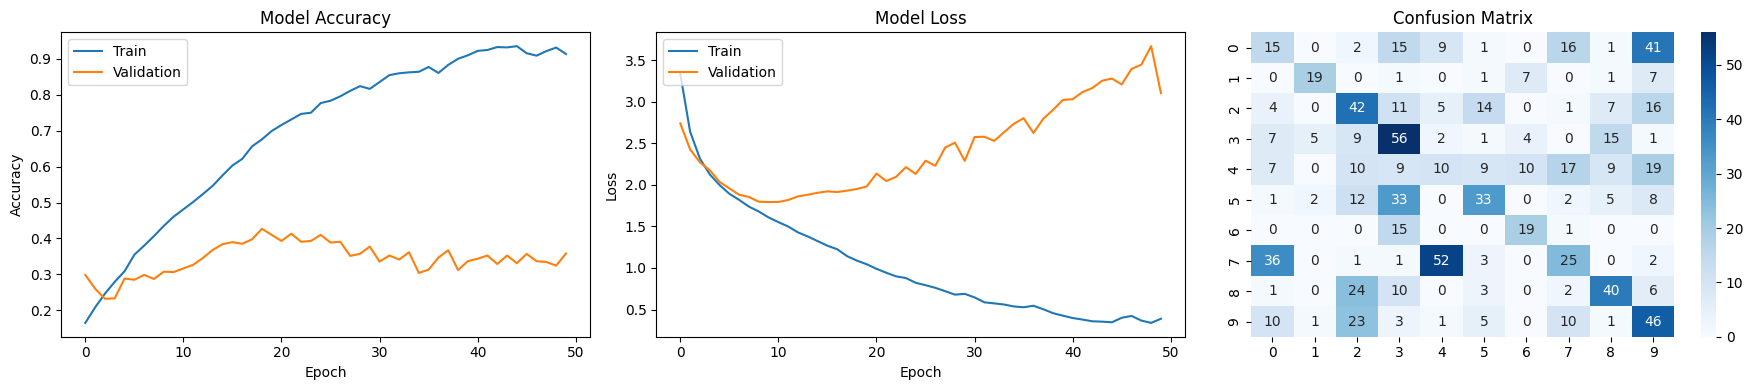

In [19]:
model = create_model2(13,345)
# compilar o modelo com o optimizer Adam
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(
    optimizer=optimizer, 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)
# treinar o modelo
LSTM_model = model.fit(
    X_train, y_train, 
    epochs=EPOCHS,
    batch_size=32, 
    shuffle=False, 
    validation_data=(X_val, y_val)
)
# prever no set de test
y_pred = model.predict(X_test)

# avaliar o modelo
y_pred_reshape = np.argmax(y_pred, axis=1)
y_test_reshape = np.argmax(y_test, axis=1)
TestLoss, Testacc = model.evaluate(X_test, y_test)

# guardar os resultados para o guardar disco/visualizar no futuro
m_metrics2 = {
    'loss': TestLoss, 
    'accuracy': Testacc, 
    'confusion_matrix': confusion_matrix(y_test_reshape, y_pred_reshape), 
    'history': model, 
    'history_dict': LSTM_model.history
}

# eliminar o modelo para começar de novo para evitar memory leak
del model
keras.backend.clear_session()
gc.collect()

print("Done.")
plot_graphs(m_metrics2)

### Apenas dropout

Epoch 1/50


c:\Users\joaob\virt_env\aprend_comp_2\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


218/218 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.1194 - loss: 2.4285 - val_accuracy: 0.3131 - val_loss: 2.0400
Epoch 2/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.1962 - loss: 2.1538 - val_accuracy: 0.2624 - val_loss: 1.9049
Epoch 3/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.2524 - loss: 2.0373 - val_accuracy: 0.2658 - val_loss: 1.9069
Epoch 4/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.2885 - loss: 1.9397 - val_accuracy: 0.2928 - val_loss: 1.9011
Epoch 5/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.3330 - loss: 1.8675 - val_accuracy: 0.3333 - val_loss: 1.8025
Epoch 6/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.3644 - loss: 1.7844 - val_accuracy: 0.3345 - val_loss: 1.7893
Epoch 7/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.3776 - loss: 1.7404 - val_accuracy: 0.3187 - val_loss: 1.7191
Epoch 8/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.4072 - loss: 1.6731 - val_accuracy: 0.327

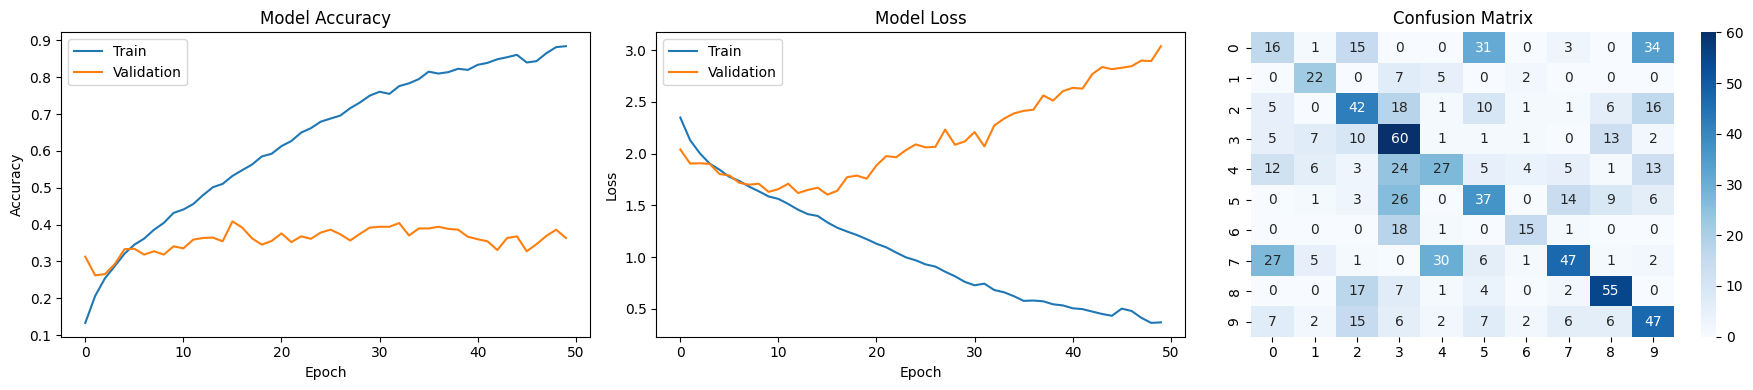

In [20]:
model = create_model3(13,345)
# compilar o modelo com o optimizer Adam
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(
    optimizer=optimizer, 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)
# treinar o modelo
LSTM_model = model.fit(
    X_train, y_train, 
    epochs=EPOCHS,
    batch_size=32, 
    shuffle=False, 
    validation_data=(X_val, y_val)
)
# prever no set de test
y_pred = model.predict(X_test)

# avaliar o modelo
y_pred_reshape = np.argmax(y_pred, axis=1)
y_test_reshape = np.argmax(y_test, axis=1)
TestLoss, Testacc = model.evaluate(X_test, y_test)

# guardar os resultados para o guardar disco/visualizar no futuro
m_metrics3 = {
    'loss': TestLoss, 
    'accuracy': Testacc, 
    'confusion_matrix': confusion_matrix(y_test_reshape, y_pred_reshape), 
    'history': model, 
    'history_dict': LSTM_model.history
}

# eliminar o modelo para começar de novo para evitar memory leak
del model
keras.backend.clear_session()
gc.collect()

print("Done.")
plot_graphs(m_metrics3)